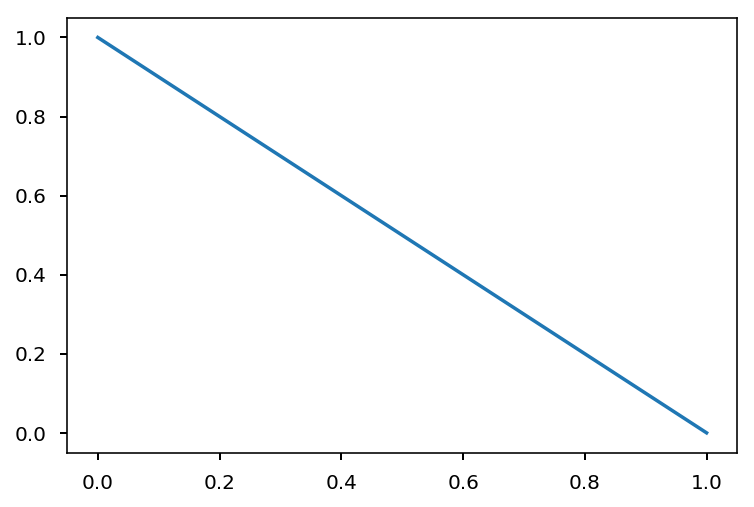

In [1]:
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'
#%inline
#import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline
plt.plot([0,1],[1,0])
plt.show()


In [2]:
import hide_imports

(-75, -56)


INFO:root:test
INFO:root:test


Import of badexp.ADEXPBackend failed due to:
No module named 'neuronunit.models.backends.badexp'
Import of bhh.BHHBackend failed due to:
No module named 'neuronunit.models.backends.bhh'
Import of general_pyNN.PYNNBackend failed due to:
No module named 'pyNN'


In [3]:

plt.clf()
import copy
%matplotlib inline

def permutations(use_test,backend):
    use_test = hide_imports.TSD(use_test)
    use_test.use_rheobase_score = True
    edges = hide_imports.model_parameters.MODEL_PARAMS[backend]
    #ga_out0 = use_test.optimize(edges,backend=backend,\
    #    protocol={'allen': False, 'elephant': True}, MU=8,NGEN=1)
    ga_out1 =  use_test.optimize(edges,backend=backend,\
        protocol={'allen': False, 'elephant': True},\
            MU=20,NGEN=8)#,seed_pop=ga_out0['pf'][0])

    
    dtc = ga_out1['pf'][0].dtc
    vm,plt = hide_imports.inject_and_plot_model(dtc)
    plt.show()
    return dtc, ga_out1['DO'], vm


In [4]:
test_frame = hide_imports.get_neab.process_all_cells()
test_frame.pop('Olfactory bulb (main) mitral cell',None)
OMObjects = []
backends = ["RAW","HH"]#,"ADEXP","BHH"]
t = test_frame['Neocortex pyramidal cell layer 5-6']



In [ ]:

backends = ["HH","RAW"]#,"ADEXP","BHH"]


for t in test_frame.values():
    b = backends[0]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    #plt.plot(vm.times,vm.magnitude)
    #plt.show()





test  InjectedCurrentAPThresholdTest prediction is None None


In [ ]:
for t in test_frame.values():
    b = backends[1]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    plt.plot(vm.times,vm.magnitude)
    plt.show()


In [ ]:
for t in test_frame.values():
    #for b in backends:
    b = backends[2]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    plt.plot(vm.times,vm.magnitude)
    plt.show()


In [ ]:
for t in test_frame.values():
    #for b in backends:
    b = backends[3]
    (dtc,DO,vm) = permutations(copy.copy(t),b)
    display(dtc.SM)
    display(dtc.obs_preds)
    plt.plot(vm.times,vm.magnitude)
    plt.show()


In [ ]:
(dtc,DO) = permutations(test_frame['Neocortex pyramidal cell layer 5-6'],"ADEXP")
display(dtc.SM)
display(dtc.obs_preds)

In [ ]:

backends = ["RAW","HH","BHH"]  



#for b in backends:
(dtc,DO) = permutations(test_frame['Neocortex pyramidal cell layer 5-6'],"RAW")


In [ ]:
backends = iter(["RAW","HH","BHH"])


from IPython.display import HTML, display

for b in backends:
    (dtc,DO) = permutations(test_frame['Neocortex pyramidal cell layer 5-6'],b)
    display(dtc.SM)
    display(dtc.obs_preds)



In [ ]:
#test_frame['Neocortex pyramidal cell layer 5-6']